# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

This project aims to build a deep neural network able to classify german traffic signs.
This notebook roughly follows the provided structure with a modification: The data set has been augmented with additional images derived from those in the training data set. 

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import numpy as np
%matplotlib inline
import cv2
import random
import matplotlib

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from math import *
import sys
# These pickle files contain the augmented data sets
x_train_file = "./datasets/x_train_augmented_test.p"
y_train_file = "./datasets/y_train_augmented_test.p"


with open(x_train_file, mode='rb') as f:
    X_train = pickle.load(f)
with open(y_train_file, mode='rb') as f:
    y_train = pickle.load(f)

with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# Number of training examples
n_train = X_train.shape[0]
n_valid = X_valid.shape[0]
# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
unique_labels = np.unique(y_train)
n_classes = len(unique_labels)

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 172000
Number of validation examples = 43000
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

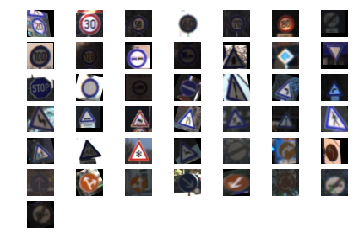

In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
# Visualizations will be shown in the notebook.
%matplotlib inline
# First, let's check what the images in the data set look like ...
i = 1
for label in unique_labels:
        # Pick the first image for each label.
        index = np.where(y_train == label)[0][0]
        image = X_train[index]
        plt.subplot(7, 7, i) 
        plt.axis('off')
        i += 1
        _ = plt.imshow(image)
plt.show()

We immediately see that some signs are well lit, well colored and quite clear, while other pictures are taken in the dark or in bad conditions. Some of the images are skewed or blurred. 

The initial distribution of the training data was highly unbalanced, some classes were much more represented than others. During the data augmentation process, I made sure that each class has roughly the same amount of images. The images added during the data augmentation process are based on the images originally found in the training data set with some slight modifications such as blurring, translating, skewing, and mirroring (for certain types of traffic signs that are symmetric).

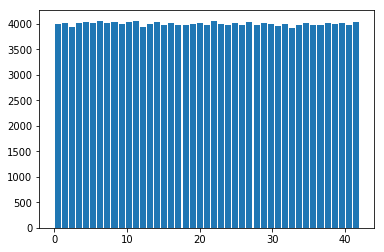

In [4]:
# Let's check the distribution of training data in terms of classes

x= np.arange(0,n_classes)
plt.hist(y_train, bins=n_classes,rwidth=0.85)
plt.show()

From this graph we can see that this dataset is highly unbalanced. 

----

## Step 2: Design and Test a Model Architecture




### Pre-process the Data Set

The pre-processing step is basically a normalization step and a color transformation so that the image colors match those of the real traffic signs that will be used as a test later on.

In [5]:

def pre_process(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = ((img - [128.0, 128.0, 128.0]) / 128.0)
    return img 
    

X_train = np.array(list(map(pre_process, X_train)))
X_valid = np.array(list(map(pre_process, X_valid)))

print("After pre-processing")
print(X_train.shape)
print(X_valid.shape)

After pre-processing
(172000, 32, 32, 3)
(43000, 32, 32, 3)


### Model Architecture

The model architecture is based on the LeNet architecture with some depth and size adjustments. Performance improved with the .65 dropout probability compared to the original values found in the LeNet network.

In [8]:

strides = {  "l1": 1, "p1": 2, 'l2': 1, 'p2': 2, 'l3': 1, 'l4':1, "out": 1}

dropout = { "l3": .65,  "l4": .65, 'out': 1.0 }


shapes = {
    'input': [32,32,3],
    'l1': [28,28,18],
    'p1': [14,14,18],
    'l2': [10,10,36],
    'p2': [5,5,36],
    'flat': [900],
    'l3': [450],
    'l4': [86],
    'out': [43]
}

pipeline = ['input', 'l1','p1',  'l2', 'p2', 'flat', 'l3', 'l4', 'out']

In [9]:
import tensorflow as tf

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [12]:
from tensorflow.contrib.layers import flatten
mu = 0
sigma = 0.1
from math import *

# Layer 1: Convolutional.
height_l1 = 1 + ceil(float(shapes['input'][0] - shapes['l1'][0] ) / float(strides['l1']))
width_l1 =  1 + ceil((shapes['input'][1] - shapes['l1'][1] ) / float(strides['l1']))
shape_l1 = [height_l1, width_l1, shapes['input'][-1], shapes['l1'][-1]]
print("Filter l1 : "+str(shape_l1))
weights_l1 = tf.Variable(tf.truncated_normal(shape_l1, mean=mu, stddev=sigma))
strides_l1 = [1, strides['l1'], strides['l1'], 1]
print("Weights l1 : "+str(weights_l1))
l1 = tf.nn.conv2d(x, weights_l1, strides=strides_l1, padding="VALID")
bias_l1 = tf.Variable(tf.zeros(shapes['l1'][-1]))
print("bias l1 : "+str(bias_l1))
l1 = tf.nn.bias_add(l1, bias_l1)
l1 = tf.nn.relu(l1, name='l1')

print(l1)
# Pooling
strides_p1 = [1, strides['p1'], strides['p1'], 1]
p1 = tf.nn.max_pool(l1, ksize=strides_p1, strides=strides_p1, padding='VALID', name='p1')
print(p1)


# Layer 2: Convolutional.
height_l2 = 1 + ceil(float(shapes['p1'][0] - shapes['l2'][0] ) / float(strides['l2']))
width_l2 =  1 + ceil((shapes['p1'][1] - shapes['l2'][1] ) / float(strides['l2']))
shape_l2 = [height_l2, width_l2, shapes['p1'][-1], shapes['l2'][-1]]
print("Filter l2 : "+str(shape_l2))
weights_l2 = tf.Variable(tf.truncated_normal(shape_l2, mean=mu, stddev=sigma))
strides_l2 = [1, strides['l2'], strides['l2'], 1]
print("Weights l2 : "+str(weights_l2))
print("Strides l2 : "+str(strides_l2))
l2 = tf.nn.conv2d(p1, weights_l2, strides=strides_l2, padding="VALID")
bias_l2 = tf.Variable(tf.zeros(shapes['l2'][-1]))
print("bias l2 : "+str(bias_l2))
l2 = tf.nn.bias_add(l2, bias_l2)
l2 = tf.nn.relu(l2, name='l1')
print(l2)


# Pooling.
strides_p2 = [1, strides['p2'], strides['p2'], 1]
p2 = tf.nn.max_pool(l2, ksize=strides_p2, strides=strides_p2, padding='VALID', name='p2')
print(p2)


# Flatten.
flat = flatten(p2)
print(flat)

# Layer 3: Fully Connected.

l3_neurons = shapes['l3'][0]
l3_incoming = shapes['flat'][0]

l3_weights = tf.Variable(tf.truncated_normal([l3_incoming, l3_neurons], mean=mu, stddev=sigma))
l3_biases = tf.Variable(tf.zeros([l3_neurons]))
l3 = tf.nn.relu(tf.add(tf.matmul(flat, l3_weights), l3_biases))
print("Weights l3 : "+str(l3_weights))
print("bias l3 : "+str(l3_biases))
l3 = tf.nn.dropout(l3, tf.constant(dropout['l3']))
print(l3)


# Layer 4: Fully Connected.

l4_neurons = shapes['l4'][0]
l4_incoming = shapes['l3'][0]

l4_weights = tf.Variable(tf.truncated_normal([l4_incoming, l4_neurons], mean=mu, stddev=sigma))
l4_biases = tf.Variable(tf.zeros([l4_neurons]))
l4 = tf.nn.relu(tf.add(tf.matmul(l3, l4_weights), l4_biases))
print("Weights l4 : "+str(l4_weights))
print("bias l4 : "+str(l4_biases))
l4 = tf.nn.dropout(l4, tf.constant(dropout['l4']))
print(l4)


# Layer 5: Fully Connected.
l5_neurons = shapes['out'][0]
l5_incoming = shapes['l4'][0]

l5_weights = tf.Variable(tf.truncated_normal([l5_incoming, l5_neurons], mean=mu, stddev=sigma))
l5_biases = tf.Variable(tf.zeros([l5_neurons]))
l5 = tf.nn.relu(tf.add(tf.matmul(l4, l5_weights), l5_biases))
print("Weights l5 : "+str(l5_weights))
print("bias l5 : "+str(l5_biases))
logits = tf.nn.dropout(l5, tf.constant(dropout['out']))
print(logits)

Filter l1 : [5, 5, 3, 18]
Weights l1 : Tensor("Variable/read:0", shape=(5, 5, 3, 18), dtype=float32)
bias l1 : Tensor("Variable_1/read:0", shape=(18,), dtype=float32)
Tensor("l1:0", shape=(?, 28, 28, 18), dtype=float32)
Tensor("p1:0", shape=(?, 14, 14, 18), dtype=float32)
Filter l2 : [5, 5, 18, 36]
Weights l2 : Tensor("Variable_2/read:0", shape=(5, 5, 18, 36), dtype=float32)
Strides l2 : [1, 1, 1, 1]
bias l2 : Tensor("Variable_3/read:0", shape=(36,), dtype=float32)
Tensor("l1_1:0", shape=(?, 10, 10, 36), dtype=float32)
Tensor("p2:0", shape=(?, 5, 5, 36), dtype=float32)
Tensor("Flatten/Reshape:0", shape=(?, 900), dtype=float32)
Weights l3 : Tensor("Variable_4/read:0", shape=(900, 450), dtype=float32)
bias l3 : Tensor("Variable_5/read:0", shape=(450,), dtype=float32)
Tensor("dropout/mul:0", shape=(?, 450), dtype=float32)
Weights l4 : Tensor("Variable_6/read:0", shape=(450, 86), dtype=float32)
bias l4 : Tensor("Variable_7/read:0", shape=(86,), dtype=float32)
Tensor("dropout_1/mul:0", shap

### Train, Validate and Test the Model

#### Evaluation progress printing functions 

In [13]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

def update_progress(progress):
    sys.stdout.write('\r[{0}{1}] {2:.2f}%'.format('#'*ceil(progress/10), ' '*(10-ceil(progress/10)), progress))


#### Learning function

In [15]:
# Learning rate
rate = 0.00004
EPOCHS = 100
BATCH_SIZE = 90
# Loss
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)

# Training operation definition (minimize loss)
optimizer = tf.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)

# Accuracy
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Model saver
saver = tf.train.Saver()

#### Actual training

In [11]:


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    print(X_train.shape)
    print("Training...")
    print()
    # For each epoch
    for i in range(EPOCHS):
        # For each batch
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            # Display progress as we go ...
            update_progress(end * 100 / num_examples)

        
        # Display accuracy after current epoch
        print("\n\nEPOCH {} ...".format(i + 1))
        validation_accuracy = evaluate(X_valid, y_valid)
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    # Save the model for later use
    saver.save(sess, './trafficsigns')

(172000, 32, 32, 3)
Training...

[###########] 100.05%

EPOCH 1 ...
Validation Accuracy = 0.250

[###########] 100.05%

EPOCH 2 ...
Validation Accuracy = 0.397

[###########] 100.05%

EPOCH 3 ...
Validation Accuracy = 0.487

[###########] 100.05%

EPOCH 4 ...
Validation Accuracy = 0.554

[###########] 100.05%

EPOCH 5 ...
Validation Accuracy = 0.608

[###########] 100.05%

EPOCH 6 ...
Validation Accuracy = 0.648

[###########] 100.05%

EPOCH 7 ...
Validation Accuracy = 0.681

[###########] 100.05%

EPOCH 8 ...
Validation Accuracy = 0.713

[###########] 100.05%

EPOCH 9 ...
Validation Accuracy = 0.734

[###########] 100.05%

EPOCH 10 ...
Validation Accuracy = 0.752

[###########] 100.05%

EPOCH 11 ...
Validation Accuracy = 0.773

[###########] 100.05%

EPOCH 12 ...
Validation Accuracy = 0.787

[###########] 100.05%

EPOCH 13 ...
Validation Accuracy = 0.803

[###########] 100.05%

EPOCH 14 ...
Validation Accuracy = 0.815

[###########] 100.05%

EPOCH 15 ...
Validation Accuracy = 0.822

[

The final accuracy is 96.2% after 100 epochs. It was still improving from the previous epoch, meaning that with more epochs, a better accuracy may potentially be achieved.

---

## Step 3: Test a Model on New Images

The test images were taken from footage of road driving in Belgium. Some of the Belgian signs are different from German ones, so this test only used signs that are similar to German signs found in the training data set.

### Load and Output the Images

(5, 32, 32, 3)


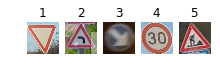

In [6]:
test_images = []
import cv2 
import numpy as np
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt



for i in range(1,6):
    img = cv2.imread('./tests/test-'+str(i)+'.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(32,32), interpolation = cv2.INTER_CUBIC)
    test_images.append(np.array(img))
    plt.subplot(1, 9, i) 
    plt.axis('off')
    plt.title(str(i))
    _ = plt.imshow(img)
    
    
test_imgs = np.array(test_images)
print(test_imgs.shape)


### Predict the Sign Type for Each Image

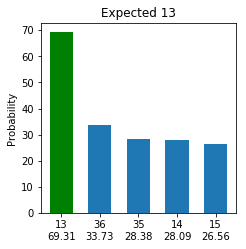

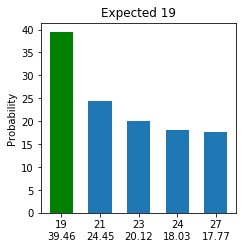

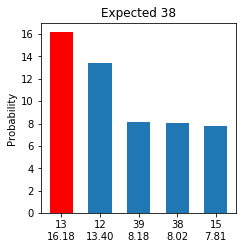

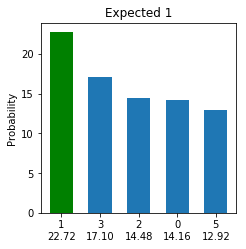

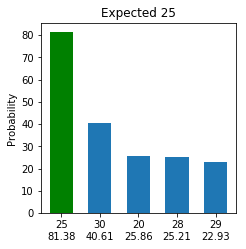

In [16]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

def pre_process_test(img):
    img = ((img - [128.0, 128.0, 128.0]) / 128.0)
    return img 

X_examples = np.array(list(map(pre_process_test, test_imgs)))
y_expected = [13,19,38,1, 25]
y_examples = []
with tf.Session() as sess:
    saver.restore(sess, './trafficsigns')

    y_examples = sess.run(logits, feed_dict={x: X_examples})
    top5 = sess.run(tf.nn.top_k(tf.constant(y_examples), k=5))

l = X_examples.shape[0]
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 3.5
fig_size[1] = 3.5
plt.rcParams["figure.figsize"] = fig_size

for i in range(0,l):
    fig, ax = plt.subplots()
    
    ind = np.arange(5)  # the x locations for the groups
    width = 0.60       # the width of the bars
    if(top5.indices[i][0] == y_expected[i]):
        barcolor = 'g'
    else:
        barcolor = 'r'
    colors = [barcolor,'C0','C0','C0','C0']
    rects1 = ax.bar(ind, top5.values[i], width, color=colors)
    ax.set_ylabel('Probability')
    ax.set_title('Expected '+str(y_expected[i]))
    ax.set_xticks(ind)
    labels = ['{:d}\n{:.2f}'.format(top5.indices[i][j],top5.values[i][j]) for j in range(0, l)]
    ax.set_xticklabels(labels)
    plt.show()



Each barchart shows the top 5 probabilities for one of the test images. The y-axis represents the probability as output by the network, and the x-axis refers to the corresponding traffic signs class (on the first line. The second line gives the numeric value of the probability). The bars are ordered by descending order of probability. The one at the left represents the best match. The line is green if it matches the expected result, and red if the sign was not detected correctly.

On the 5 images, only the darkest and blurriest one was not predicted accurately, and the classifier ranked the correct class as 4th. Even the class with the highest probability only has a 16% probability. 
For all other signs, the correct class was detected accurately with higher levels of confidence. 

### Analyze Performance

In [20]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
performance = np.mean([top5.indices[i][0] == y_expected[i] for i in range(0, len(y_expected))])

print("Accuracy = {:4.2f}".format(performance))

Accuracy = 0.80


4 on 5 corresponds to 80% performance

---

## Step 4: Visualize the Neural Network's State with Test Images


In [18]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

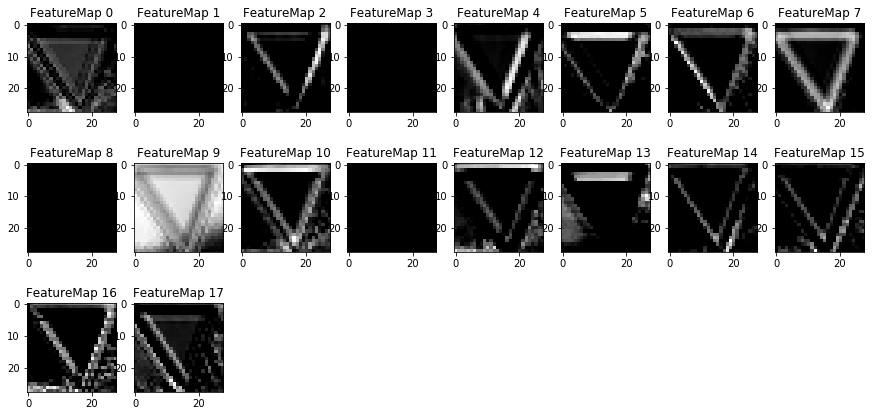

In [19]:
with tf.Session() as sess:
    saver.restore(sess, './trafficsigns')
    outputFeatureMap([test_images[0]], l1)

### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**

The visualisation of the feature maps shows that the first layer learned to detect edges in traffic signs.